# Pretrained model weights are not frozen it changes during training
 unless  explicitly set them to requires_grad=False
 
 #Freeze the pretrained layers
        for param in self.convnet.parameters():
            param.requires_grad = False

import os
import random
import shutil

def split_images(image_dir, train_dir, valid_dir, validation_percentage=20):
    # Create train and validation directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    # Collect all .tiff files from all subdirectories
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.tiff', 'tiff')):
                image_files.append(os.path.join(root, file))

    # Shuffle the files randomly
    random.shuffle(image_files)

    # Split the images into training and validation sets
    total_images = len(image_files)
    validation_count = int(total_images * validation_percentage / 100)

    validation_files = image_files[:validation_count]
    training_files = image_files[validation_count:]

    # Move files to train and validation directories
    for file_path in training_files:
        destination = os.path.join(train_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    for file_path in validation_files:
        destination = os.path.join(valid_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    print(f"Total images: {total_images}")
    print(f"Training images: {len(training_files)}")
    print(f"Validation images: {len(validation_files)}")

# Example usage
image_dir = r"../../tiff_experiment_unsupervised_data/combined"
train_dir = r"../../tiff_experiment_unsupervised_data/train"
valid_dir = r"../../tiff_experiment_unsupervised_data/validation"

split_images(image_dir, train_dir, valid_dir, validation_percentage=20)


In [24]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
from helper import set_seed

from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import functional as Func

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('.tiff', '.tif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
    
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        
        return image1, image2, image
    
# 96 *96 chosen initially because if we can get good result with this we can get good permofamce with 224 or bigger size for sure since we bigger size doesn't loose that ,uch information. 
#  ORDER OF AUG IS IMPORTANT: FIRST CROP THEN COLOR DIST AS ORIG SIMCLR PAPER GET 1 % increase in accuracy also helps compuational efficiency
contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=96, scale=(0.4, 1)), #std is size=224 and scale = 0.08 to 1. i didn' wanna do it because then the model learns to invariant to smaller portion of color.
    transforms.RandomHorizontalFlip(p=0.5),  #std simclr with p =0.5
    transforms.RandomVerticalFlip(p=0.5), #i added in natural images cat can't flip vertically but in my case i can
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(5, sigma=(0.1, 1)) #std p= 0.5 .simclr randomly sample σ ∈ [0.1, 2.0], and the kernel size is set to be 10% of the image height/width. # 9 is the 10% of hight (96) since resizecrop to 96 already loosing info, i wanna reduce bluring. less kernal size and less  less blur
    ], p=0.5),
    transforms.RandomApply([
    transforms.ColorJitter(brightness=(0.15)) 
    ], p=0.7),  #std p = 0.8  I gave p =0.7 so that it can also see original dist more. also strenght of data aug was 0.8 mine is 0.2 and 0.3 because more strenght desotrys original.
    
])

resize_transform = transforms.Compose([
    transforms.Resize((96, 96))
])

image_dir = r"../../crop_simclr/train_plus_val"
inference_dir = r"../../crop_simclr/inference"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
inference_dataset = ImageDataset(image_dir=inference_dir, transform=resize_transform)

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

batch_size = 64

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=False, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=False, num_workers=0)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=False, num_workers=0)

In [4]:
# Calculate the total number of images in train, validation, and inference datasets
total_train_images = len(train_dataset)
total_val_images = len(val_dataset)
total_inference_images = len(inference_dataset)

# Print the totals
print(f"Total train images: {total_train_images}")
print(f"Total validation images: {total_val_images}")
print(f"Total inference images: {total_inference_images}")


Total train images: 903
Total validation images: 225
Total inference images: 127


In [5]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([64, 3, 96, 96])
  Image2: torch.Size([64, 3, 96, 96])
  image: torch.Size([64, 3, 2054, 2054])


In [6]:
for i, (image1, image2, image) in enumerate(val_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([64, 3, 96, 96])
  Image2: torch.Size([64, 3, 96, 96])
  image: torch.Size([64, 3, 2054, 2054])


In [7]:
for i, (image1, image2, image) in enumerate(inference_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([64, 3, 96, 96])
  Image2: torch.Size([64, 3, 96, 96])
  image: torch.Size([64, 3, 2054, 2054])


Dataset specific normalisation: Normalise using computed mean and std of our special dataset instead of just mean = 0.5,std =0.5

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


mean,std = compute_mean_std(train_loader)
print(mean)
print(std)

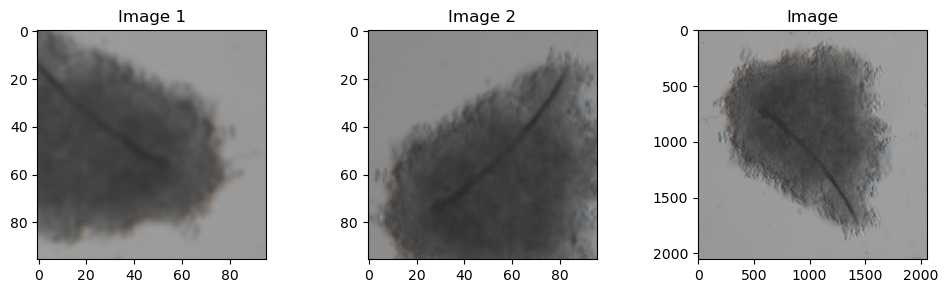

In [8]:
import matplotlib.pyplot as plt

for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first image from the batch
    image1 = image1[0].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[0].numpy().transpose(1, 2, 0)
    image = image[0].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


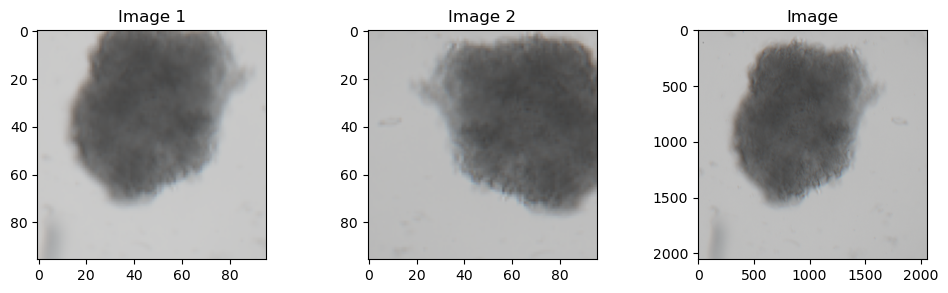

In [9]:
import matplotlib.pyplot as plt

for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first image from the batch
    image1 = image1[1].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[1].numpy().transpose(1, 2, 0)
    image = image[1].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


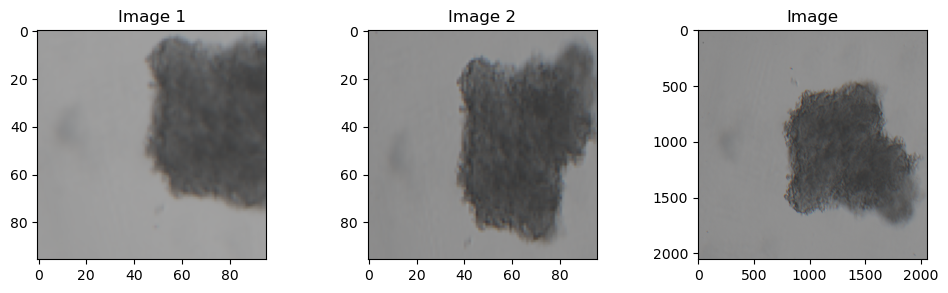

In [10]:
import matplotlib.pyplot as plt

for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first image from the batch
    image1 = image1[2].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[2].numpy().transpose(1, 2, 0)
    image = image[2].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


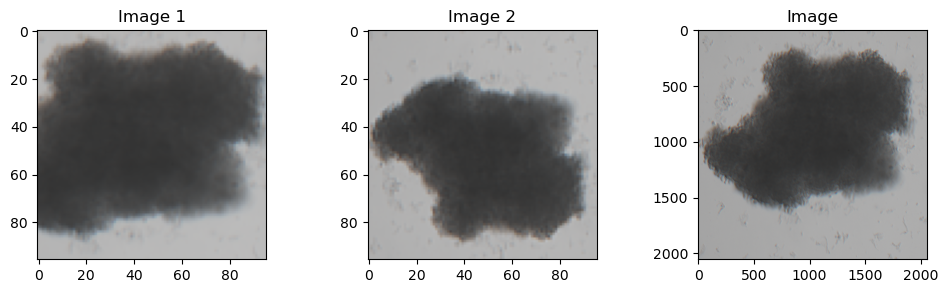

In [11]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(val_loader):
    # Select the first image from the batch
    image1 = image1[0].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[0].numpy().transpose(1, 2, 0)
    image = image[0].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


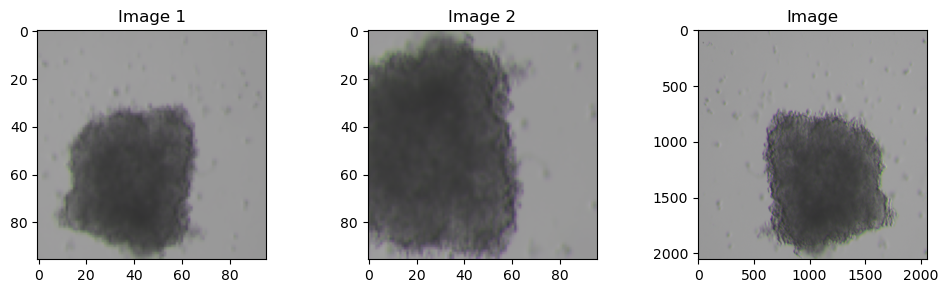

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(val_loader):
    # Select the first image from the batch
    image1 = image1[1].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[1].numpy().transpose(1, 2, 0)
    image = image[1].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


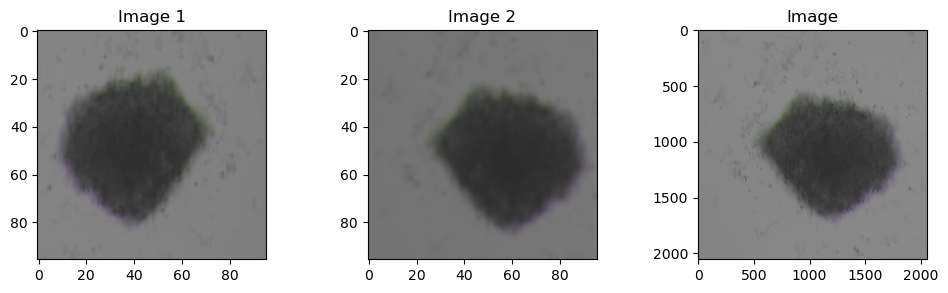

In [13]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(val_loader):
    # Select the first image from the batch
    image1 = image1[2].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[2].numpy().transpose(1, 2, 0)
    image = image[2].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


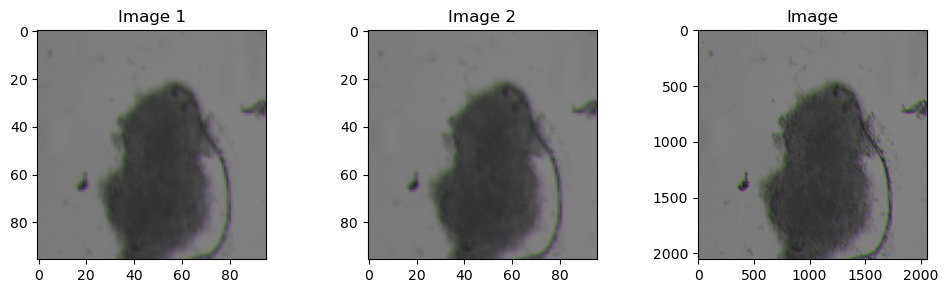

In [14]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(inference_loader):
    # Select the first image from the batch
    image1 = image1[0].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image2 = image2[0].numpy().transpose(1, 2, 0)
    image = image[0].numpy().transpose(1, 2, 0)  # Ensure this is (H, W, C) for RGB

    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


Image 1 shape: (96, 96, 3)
Image 2 shape: (96, 96, 3)
Image shape: (2054, 2054, 3)


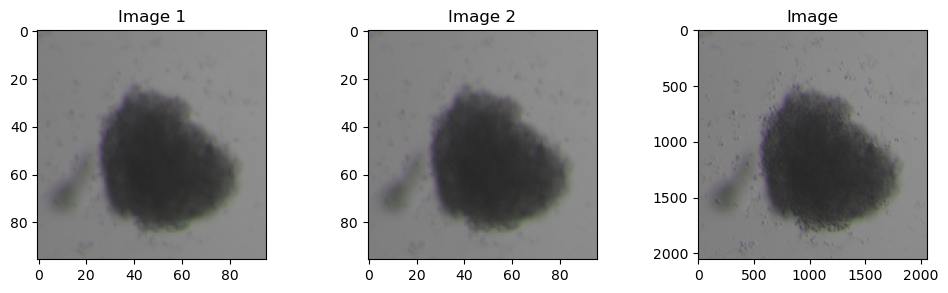

In [15]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(inference_loader):
    # Ensure the images are converted properly
    image1 = image1[1].numpy().transpose(1, 2, 0)  # (H, W, C)
    image2 = image2[1].numpy().transpose(1, 2, 0)
    image = image[1].numpy().transpose(1, 2, 0)

    # Check the shapes
    print(f"Image 1 shape: {image1.shape}")  # Should be (H, W, 3)
    print(f"Image 2 shape: {image2.shape}")  # Should be (H, W, 3)
    print(f"Image shape: {image.shape}")     # Should be (H, W, 3)

    # Plot the images
    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)  # No cmap, displays in RGB
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)  # No cmap, displays in RGB
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)  # No cmap, displays in RGB
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


Image 1 shape: (96, 96, 3)
Image 2 shape: (96, 96, 3)
Image shape: (2054, 2054, 3)


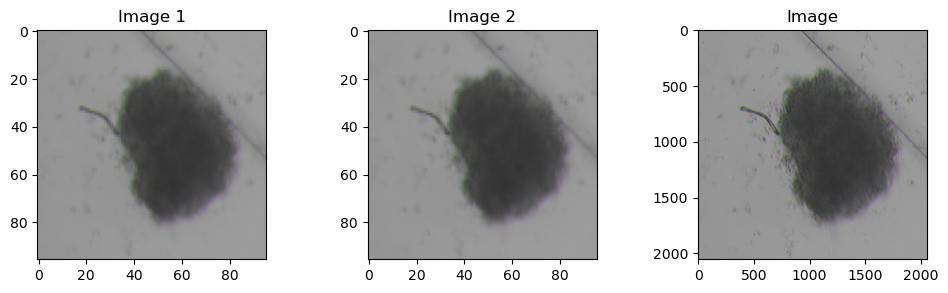

In [16]:
import matplotlib.pyplot as plt
import numpy as np

for i, (image1, image2, image) in enumerate(inference_loader):
    # Ensure the images are converted properly
    image1 = image1[2].numpy().transpose(1, 2, 0)  # (H, W, C)
    image2 = image2[2].numpy().transpose(1, 2, 0)
    image = image[2].numpy().transpose(1, 2, 0)

    # Check the shapes
    print(f"Image 1 shape: {image1.shape}")  # Should be (H, W, 3)
    print(f"Image 2 shape: {image2.shape}")  # Should be (H, W, 3)
    print(f"Image shape: {image.shape}")     # Should be (H, W, 3)

    # Plot the images
    plt.figure(figsize=(10, 3))

    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1)  # No cmap, displays in RGB
    plt.title('Image 1')

    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2)  # No cmap, displays in RGB
    plt.title('Image 2')

    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image)  # No cmap, displays in RGB
    plt.title('Image')

    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


## SIMCLR

In [17]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [18]:
def plot_curves(train_losses, val_losses,inference_losses, train_top1_accs, val_top1_accs,inference_top1_accs, train_top5_accs, val_top5_accs,inference_top5_accs, train_mean_pos, val_mean_pos,inference_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(20, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.plot(epochs, inference_losses, 'go-', label='Inference Loss')
    plt.title('Training, Validation, and Inference Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.plot(epochs, inference_top1_accs, 'go-', label='Inference Top-1 Accuracy')
    plt.title('Training, Validation, and Inference Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.plot(epochs, inference_top5_accs, 'go-', label='Inference Top-5 Accuracy')
    plt.title('Training, Validation, and Inference Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.plot(epochs, inference_mean_pos, 'go-', label='Inference Mean Positive Position')
    plt.title('Training, Validation, and Inference Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay, max_epochs=max_epochs).to(device)

    # Lists to store the metrics
    train_losses, val_losses, inference_losses = [], [], []
    train_top1_accs, val_top1_accs, inference_top1_accs = [], [], []
    train_top5_accs, val_top5_accs, inference_top5_accs = [], [], []
    train_mean_pos, val_mean_pos, inference_mean_pos = [], [], []

    start_time = time.time()

    # Adjust the training loop to start from start_epoch
    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        inference_loss, inference_top1_acc, inference_top5_acc, inference_mean_pos_val = model.inference_epoch(inference_loader, device)

        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        inference_losses.append(inference_loss)

        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        inference_top1_accs.append(inference_top1_acc)

        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        inference_top5_accs.append(inference_top5_acc)

        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        inference_mean_pos.append(inference_mean_pos_val)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Top-1 Acc: {train_top1_acc:.2f}% | Train Top-5 Acc: {train_top5_acc:.2f}% | Train Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Val Top-1 Acc: {val_top1_acc:.2f}% | Val Top-5 Acc: {val_top5_acc:.2f}% | Val Mean Pos: {val_mean_pos_val:.2f} | "
              f"Infer Loss: {inference_loss:.4f} | Infer Top-1 Acc: {inference_top1_acc:.2f}% | Infer Top-5 Acc: {inference_top5_acc:.2f}% | Infer Mean Pos: {inference_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")
        
        # Step the learning rate scheduler once per epoch
        model.lr_scheduler.step()

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results including inference metrics
    plot_curves(train_losses, val_losses, inference_losses,
                train_top1_accs, val_top1_accs, inference_top1_accs,
                train_top5_accs, val_top5_accs, inference_top5_accs,
                train_mean_pos, val_mean_pos, inference_mean_pos)

    # Return model and all metrics
    metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "inference_losses": inference_losses,
        "train_top1_accs": train_top1_accs,
        "val_top1_accs": val_top1_accs,
        "inference_top1_accs": inference_top1_accs,
        "train_top5_accs": train_top5_accs,
        "val_top5_accs": val_top5_accs,
        "inference_top5_accs": inference_top5_accs,
        "train_mean_pos": train_mean_pos,
        "val_mean_pos": val_mean_pos,
        "inference_mean_pos": inference_mean_pos
    }
    return model, metrics


Using device: cuda


Epoch 1/245 | Train Loss: 3.1462 | Train Top-1 Acc: 0.24% | Train Top-5 Acc: 0.51% | Train Mean Pos: 13.15 | Val Loss: 3.9422 | Val Top-1 Acc: 0.17% | Val Top-5 Acc: 0.39% | Val Mean Pos: 19.75 | Infer Loss: 3.2352 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.92 seconds


Epoch 2/245 | Train Loss: 2.3350 | Train Top-1 Acc: 0.34% | Train Top-5 Acc: 0.71% | Train Mean Pos: 5.36 | Val Loss: 3.3809 | Val Top-1 Acc: 0.20% | Val Top-5 Acc: 0.49% | Val Mean Pos: 12.75 | Infer Loss: 2.7193 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.99 seconds


Epoch 3/245 | Train Loss: 1.9825 | Train Top-1 Acc: 0.43% | Train Top-5 Acc: 0.79% | Train Mean Pos: 3.84 | Val Loss: 2.4016 | Val Top-1 Acc: 0.35% | Val Top-5 Acc: 0.71% | Val Mean Pos: 5.56 | Infer Loss: 1.5435 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.63 seconds


Epoch 4/245 | Train Loss: 1.8020 | Train Top-1 Acc: 0.48% | Train Top-5 Acc: 0.82% | Train Mean Pos: 3.52 | Val Loss: 1.7540 | Val Top-1 Acc: 0.49% | Val Top-5 Acc: 0.88% | Val Mean Pos: 3.08 | Infer Loss: 1.1079 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.78 seconds


Epoch 5/245 | Train Loss: 1.5616 | Train Top-1 Acc: 0.53% | Train Top-5 Acc: 0.87% | Train Mean Pos: 2.89 | Val Loss: 1.7062 | Val Top-1 Acc: 0.54% | Val Top-5 Acc: 0.87% | Val Mean Pos: 3.04 | Infer Loss: 1.1575 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.65 seconds


Epoch 6/245 | Train Loss: 1.3253 | Train Top-1 Acc: 0.60% | Train Top-5 Acc: 0.92% | Train Mean Pos: 2.39 | Val Loss: 1.5145 | Val Top-1 Acc: 0.58% | Val Top-5 Acc: 0.90% | Val Mean Pos: 2.68 | Infer Loss: 0.9380 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.82 seconds


Epoch 7/245 | Train Loss: 1.2357 | Train Top-1 Acc: 0.64% | Train Top-5 Acc: 0.93% | Train Mean Pos: 2.17 | Val Loss: 1.3106 | Val Top-1 Acc: 0.64% | Val Top-5 Acc: 0.93% | Val Mean Pos: 2.21 | Infer Loss: 0.8884 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.50 seconds


Epoch 8/245 | Train Loss: 1.2270 | Train Top-1 Acc: 0.65% | Train Top-5 Acc: 0.92% | Train Mean Pos: 2.18 | Val Loss: 1.5000 | Val Top-1 Acc: 0.56% | Val Top-5 Acc: 0.89% | Val Mean Pos: 2.54 | Infer Loss: 0.9583 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.83 seconds


Epoch 9/245 | Train Loss: 1.1282 | Train Top-1 Acc: 0.70% | Train Top-5 Acc: 0.93% | Train Mean Pos: 2.07 | Val Loss: 1.3601 | Val Top-1 Acc: 0.60% | Val Top-5 Acc: 0.92% | Val Mean Pos: 2.33 | Infer Loss: 0.8543 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.32 seconds


Epoch 10/245 | Train Loss: 0.9860 | Train Top-1 Acc: 0.72% | Train Top-5 Acc: 0.95% | Train Mean Pos: 1.79 | Val Loss: 1.3109 | Val Top-1 Acc: 0.61% | Val Top-5 Acc: 0.91% | Val Mean Pos: 2.31 | Infer Loss: 0.8033 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.98 seconds


Epoch 11/245 | Train Loss: 0.9323 | Train Top-1 Acc: 0.73% | Train Top-5 Acc: 0.96% | Train Mean Pos: 1.76 | Val Loss: 1.3272 | Val Top-1 Acc: 0.67% | Val Top-5 Acc: 0.92% | Val Mean Pos: 2.33 | Infer Loss: 1.0446 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.27 seconds


Epoch 12/245 | Train Loss: 0.8750 | Train Top-1 Acc: 0.77% | Train Top-5 Acc: 0.96% | Train Mean Pos: 1.67 | Val Loss: 1.1761 | Val Top-1 Acc: 0.67% | Val Top-5 Acc: 0.94% | Val Mean Pos: 2.13 | Infer Loss: 0.6008 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.05 seconds


Epoch 13/245 | Train Loss: 0.7508 | Train Top-1 Acc: 0.79% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.49 | Val Loss: 1.1353 | Val Top-1 Acc: 0.68% | Val Top-5 Acc: 0.94% | Val Mean Pos: 2.19 | Infer Loss: 0.5530 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.88 seconds


Epoch 14/245 | Train Loss: 0.7259 | Train Top-1 Acc: 0.79% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.47 | Val Loss: 0.9662 | Val Top-1 Acc: 0.72% | Val Top-5 Acc: 0.96% | Val Mean Pos: 1.73 | Infer Loss: 0.6485 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.66 seconds


Epoch 15/245 | Train Loss: 0.7248 | Train Top-1 Acc: 0.80% | Train Top-5 Acc: 0.97% | Train Mean Pos: 1.51 | Val Loss: 0.9930 | Val Top-1 Acc: 0.72% | Val Top-5 Acc: 0.95% | Val Mean Pos: 1.98 | Infer Loss: 0.4204 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.59 seconds


Epoch 16/245 | Train Loss: 0.6685 | Train Top-1 Acc: 0.82% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.47 | Val Loss: 0.8414 | Val Top-1 Acc: 0.75% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.62 | Infer Loss: 0.4915 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.29 seconds


Epoch 17/245 | Train Loss: 0.6781 | Train Top-1 Acc: 0.79% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.47 | Val Loss: 0.8062 | Val Top-1 Acc: 0.78% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.56 | Infer Loss: 0.4716 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.20 seconds


Epoch 18/245 | Train Loss: 0.6269 | Train Top-1 Acc: 0.82% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.39 | Val Loss: 0.8766 | Val Top-1 Acc: 0.78% | Val Top-5 Acc: 0.96% | Val Mean Pos: 1.55 | Infer Loss: 0.5785 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.18 seconds


Epoch 19/245 | Train Loss: 0.7320 | Train Top-1 Acc: 0.79% | Train Top-5 Acc: 0.97% | Train Mean Pos: 1.53 | Val Loss: 1.1086 | Val Top-1 Acc: 0.72% | Val Top-5 Acc: 0.96% | Val Mean Pos: 1.93 | Infer Loss: 1.0201 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.07 seconds


Epoch 20/245 | Train Loss: 0.7598 | Train Top-1 Acc: 0.77% | Train Top-5 Acc: 0.97% | Train Mean Pos: 1.57 | Val Loss: 0.9766 | Val Top-1 Acc: 0.77% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.62 | Infer Loss: 0.5713 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.58 seconds


Epoch 21/245 | Train Loss: 0.7818 | Train Top-1 Acc: 0.79% | Train Top-5 Acc: 0.97% | Train Mean Pos: 1.64 | Val Loss: 1.0314 | Val Top-1 Acc: 0.69% | Val Top-5 Acc: 0.95% | Val Mean Pos: 1.93 | Infer Loss: 0.6036 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.20 seconds


Epoch 22/245 | Train Loss: 0.5769 | Train Top-1 Acc: 0.84% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.40 | Val Loss: 0.8142 | Val Top-1 Acc: 0.77% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.57 | Infer Loss: 0.4587 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.95 seconds


Epoch 23/245 | Train Loss: 0.5401 | Train Top-1 Acc: 0.86% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.30 | Val Loss: 0.7692 | Val Top-1 Acc: 0.78% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.52 | Infer Loss: 0.3126 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.95 seconds


Epoch 24/245 | Train Loss: 0.5283 | Train Top-1 Acc: 0.86% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.31 | Val Loss: 1.0032 | Val Top-1 Acc: 0.77% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.76 | Infer Loss: 0.6722 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.67 seconds


Epoch 25/245 | Train Loss: 0.5161 | Train Top-1 Acc: 0.86% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.31 | Val Loss: 0.8853 | Val Top-1 Acc: 0.75% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.72 | Infer Loss: 0.5152 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.92 seconds


Epoch 26/245 | Train Loss: 0.4533 | Train Top-1 Acc: 0.88% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.25 | Val Loss: 0.6774 | Val Top-1 Acc: 0.83% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.50 | Infer Loss: 0.4490 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.37 seconds


Epoch 27/245 | Train Loss: 0.5153 | Train Top-1 Acc: 0.86% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.29 | Val Loss: 0.8161 | Val Top-1 Acc: 0.80% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.58 | Infer Loss: 0.4491 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.32 seconds


Epoch 28/245 | Train Loss: 0.7804 | Train Top-1 Acc: 0.79% | Train Top-5 Acc: 0.97% | Train Mean Pos: 1.67 | Val Loss: 1.2525 | Val Top-1 Acc: 0.65% | Val Top-5 Acc: 0.93% | Val Mean Pos: 2.22 | Infer Loss: 0.6712 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.05 seconds


Epoch 29/245 | Train Loss: 0.7222 | Train Top-1 Acc: 0.79% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.53 | Val Loss: 0.9441 | Val Top-1 Acc: 0.77% | Val Top-5 Acc: 0.96% | Val Mean Pos: 1.65 | Infer Loss: 0.5875 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.17 seconds


Epoch 30/245 | Train Loss: 0.5988 | Train Top-1 Acc: 0.84% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.40 | Val Loss: 0.9424 | Val Top-1 Acc: 0.72% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.71 | Infer Loss: 0.5482 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.19 seconds


Epoch 31/245 | Train Loss: 0.5007 | Train Top-1 Acc: 0.86% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.30 | Val Loss: 0.9223 | Val Top-1 Acc: 0.74% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.64 | Infer Loss: 0.5747 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.82 seconds


Epoch 32/245 | Train Loss: 0.4240 | Train Top-1 Acc: 0.89% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.23 | Val Loss: 0.8865 | Val Top-1 Acc: 0.77% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.54 | Infer Loss: 0.6242 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.83 seconds


Epoch 33/245 | Train Loss: 0.3950 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.22 | Val Loss: 0.6245 | Val Top-1 Acc: 0.84% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.31 | Infer Loss: 0.3579 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.18 seconds


Epoch 34/245 | Train Loss: 0.4119 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.21 | Val Loss: 0.5438 | Val Top-1 Acc: 0.87% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.25 | Infer Loss: 0.3515 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.48 seconds


Epoch 35/245 | Train Loss: 0.4351 | Train Top-1 Acc: 0.89% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.24 | Val Loss: 0.6883 | Val Top-1 Acc: 0.84% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.35 | Infer Loss: 0.5032 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.80 seconds


Epoch 36/245 | Train Loss: 0.3778 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.19 | Val Loss: 0.6354 | Val Top-1 Acc: 0.85% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.44 | Infer Loss: 0.2942 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.31 seconds


Epoch 37/245 | Train Loss: 0.3937 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.18 | Val Loss: 0.7150 | Val Top-1 Acc: 0.84% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.47 | Infer Loss: 0.3876 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.30 seconds


Epoch 38/245 | Train Loss: 0.3700 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.18 | Val Loss: 0.8019 | Val Top-1 Acc: 0.80% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.68 | Infer Loss: 0.4289 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.13 seconds


Epoch 39/245 | Train Loss: 0.3469 | Train Top-1 Acc: 0.91% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.21 | Val Loss: 0.5078 | Val Top-1 Acc: 0.91% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.12 | Infer Loss: 0.3088 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.78 seconds


Epoch 40/245 | Train Loss: 0.3285 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.14 | Val Loss: 0.5618 | Val Top-1 Acc: 0.85% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.30 | Infer Loss: 0.2730 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.47 seconds


Epoch 41/245 | Train Loss: 0.3031 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.13 | Val Loss: 0.4941 | Val Top-1 Acc: 0.88% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.26 | Infer Loss: 0.2606 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.26 seconds


Epoch 42/245 | Train Loss: 0.3555 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.23 | Val Loss: 0.6377 | Val Top-1 Acc: 0.85% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.33 | Infer Loss: 0.4111 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.84 seconds


Epoch 43/245 | Train Loss: 0.3093 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.13 | Val Loss: 0.4989 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.20 | Infer Loss: 0.2621 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.83 seconds


Epoch 44/245 | Train Loss: 0.2723 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.11 | Val Loss: 0.4892 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.25 | Infer Loss: 0.2721 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.39 seconds


Epoch 45/245 | Train Loss: 0.2738 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.11 | Val Loss: 0.6121 | Val Top-1 Acc: 0.85% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.37 | Infer Loss: 0.3131 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.95 seconds


Epoch 46/245 | Train Loss: 0.2967 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.14 | Val Loss: 0.6695 | Val Top-1 Acc: 0.83% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.59 | Infer Loss: 0.3527 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.58 seconds


Epoch 47/245 | Train Loss: 0.3044 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.14 | Val Loss: 0.6981 | Val Top-1 Acc: 0.83% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.38 | Infer Loss: 0.3755 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.19 seconds


Epoch 48/245 | Train Loss: 0.2991 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.14 | Val Loss: 0.5609 | Val Top-1 Acc: 0.86% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.31 | Infer Loss: 0.2561 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.63 seconds


Epoch 49/245 | Train Loss: 0.2524 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.5115 | Val Top-1 Acc: 0.88% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.25 | Infer Loss: 0.2982 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.25 seconds


Epoch 50/245 | Train Loss: 0.2606 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.3815 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.20 | Infer Loss: 0.1552 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.67 seconds


Epoch 51/245 | Train Loss: 0.2536 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.09 | Val Loss: 0.6312 | Val Top-1 Acc: 0.85% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.30 | Infer Loss: 0.3799 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.38 seconds


Epoch 52/245 | Train Loss: 0.2382 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.09 | Val Loss: 0.5866 | Val Top-1 Acc: 0.84% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.38 | Infer Loss: 0.2990 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.48 seconds


Epoch 53/245 | Train Loss: 0.2831 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.14 | Val Loss: 0.5696 | Val Top-1 Acc: 0.86% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.32 | Infer Loss: 0.2233 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.75 seconds


Epoch 54/245 | Train Loss: 0.2408 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.11 | Val Loss: 0.5195 | Val Top-1 Acc: 0.87% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.31 | Infer Loss: 0.2640 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.55 seconds


Epoch 55/245 | Train Loss: 0.2595 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.12 | Val Loss: 0.4141 | Val Top-1 Acc: 0.91% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.19 | Infer Loss: 0.2372 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.90 seconds


Epoch 56/245 | Train Loss: 0.2391 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.4742 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.21 | Infer Loss: 0.2084 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.93 seconds


Epoch 57/245 | Train Loss: 0.2258 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.4774 | Val Top-1 Acc: 0.86% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.28 | Infer Loss: 0.2675 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.44 seconds


Epoch 58/245 | Train Loss: 0.2454 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.4195 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.18 | Infer Loss: 0.2120 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.97 seconds


Epoch 59/245 | Train Loss: 0.3288 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.15 | Val Loss: 0.5598 | Val Top-1 Acc: 0.86% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.43 | Infer Loss: 0.2747 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.09 seconds


Epoch 60/245 | Train Loss: 0.3022 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.14 | Val Loss: 0.7202 | Val Top-1 Acc: 0.85% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.51 | Infer Loss: 0.6731 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.27 seconds


Epoch 61/245 | Train Loss: 0.2970 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.18 | Val Loss: 0.4688 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.22 | Infer Loss: 0.2832 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.98 seconds


Epoch 62/245 | Train Loss: 0.2656 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.12 | Val Loss: 0.3531 | Val Top-1 Acc: 0.93% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.11 | Infer Loss: 0.2128 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.25 seconds


Epoch 63/245 | Train Loss: 0.2502 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.12 | Val Loss: 0.4100 | Val Top-1 Acc: 0.91% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.19 | Infer Loss: 0.1885 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.45 seconds


Epoch 64/245 | Train Loss: 0.2398 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.4444 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.22 | Infer Loss: 0.2325 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.68 seconds


Epoch 65/245 | Train Loss: 0.2473 | Train Top-1 Acc: 0.94% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.12 | Val Loss: 0.4311 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.16 | Infer Loss: 0.2163 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.37 seconds


Epoch 66/245 | Train Loss: 0.2470 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.6245 | Val Top-1 Acc: 0.86% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.35 | Infer Loss: 0.3487 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.40 seconds


Epoch 67/245 | Train Loss: 0.2219 | Train Top-1 Acc: 0.96% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.5611 | Val Top-1 Acc: 0.87% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.24 | Infer Loss: 0.2925 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.69 seconds


Epoch 68/245 | Train Loss: 0.2308 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.4711 | Val Top-1 Acc: 0.88% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.22 | Infer Loss: 0.2383 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.37 seconds


Epoch 69/245 | Train Loss: 0.2264 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.6182 | Val Top-1 Acc: 0.86% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.31 | Infer Loss: 0.3167 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.97 seconds


Epoch 70/245 | Train Loss: 0.2290 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.4708 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.20 | Infer Loss: 0.2342 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.35 seconds


Epoch 71/245 | Train Loss: 0.2301 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.11 | Val Loss: 0.5776 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.35 | Infer Loss: 0.2670 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.16 seconds


Epoch 72/245 | Train Loss: 0.2271 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.09 | Val Loss: 0.6613 | Val Top-1 Acc: 0.87% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.56 | Infer Loss: 0.2665 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.67 seconds


Epoch 73/245 | Train Loss: 0.3618 | Train Top-1 Acc: 0.91% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.21 | Val Loss: 0.8275 | Val Top-1 Acc: 0.81% | Val Top-5 Acc: 0.96% | Val Mean Pos: 2.19 | Infer Loss: 0.3307 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.33 seconds


Epoch 74/245 | Train Loss: 0.5357 | Train Top-1 Acc: 0.87% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.40 | Val Loss: 0.9580 | Val Top-1 Acc: 0.79% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.57 | Infer Loss: 0.6557 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.08 seconds


Epoch 75/245 | Train Loss: 0.4531 | Train Top-1 Acc: 0.89% | Train Top-5 Acc: 0.98% | Train Mean Pos: 1.28 | Val Loss: 0.6962 | Val Top-1 Acc: 0.81% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.54 | Infer Loss: 0.3288 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.11 seconds


Epoch 76/245 | Train Loss: 0.3901 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.22 | Val Loss: 0.5272 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.27 | Infer Loss: 0.3143 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.47 seconds


Epoch 77/245 | Train Loss: 0.3136 | Train Top-1 Acc: 0.92% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.14 | Val Loss: 0.4744 | Val Top-1 Acc: 0.86% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.23 | Infer Loss: 0.2260 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 81.97 seconds


Epoch 78/245 | Train Loss: 0.4092 | Train Top-1 Acc: 0.90% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.28 | Val Loss: 1.0233 | Val Top-1 Acc: 0.80% | Val Top-5 Acc: 0.97% | Val Mean Pos: 1.56 | Infer Loss: 0.7635 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.80 seconds


Epoch 79/245 | Train Loss: 0.3935 | Train Top-1 Acc: 0.91% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.27 | Val Loss: 0.5382 | Val Top-1 Acc: 0.87% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.31 | Infer Loss: 0.2764 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.10 seconds


Epoch 80/245 | Train Loss: 0.2973 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.12 | Val Loss: 0.4610 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.22 | Infer Loss: 0.1792 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.38 seconds


Epoch 81/245 | Train Loss: 0.2562 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.10 | Val Loss: 0.5815 | Val Top-1 Acc: 0.84% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.35 | Infer Loss: 0.2494 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.27 seconds


Epoch 82/245 | Train Loss: 0.2728 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.13 | Val Loss: 0.5467 | Val Top-1 Acc: 0.88% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.32 | Infer Loss: 0.2350 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.70 seconds


Epoch 83/245 | Train Loss: 0.2248 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.09 | Val Loss: 0.4353 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.23 | Infer Loss: 0.1638 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 85.65 seconds


Epoch 84/245 | Train Loss: 0.1985 | Train Top-1 Acc: 0.96% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.4350 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.20 | Infer Loss: 0.2299 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.15 seconds


Epoch 85/245 | Train Loss: 0.2091 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.3871 | Val Top-1 Acc: 0.91% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.21 | Infer Loss: 0.1774 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.08 seconds


Epoch 86/245 | Train Loss: 0.1802 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.06 | Val Loss: 0.3606 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.16 | Infer Loss: 0.1187 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.17 seconds


Epoch 87/245 | Train Loss: 0.1579 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.06 | Val Loss: 0.3894 | Val Top-1 Acc: 0.91% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.18 | Infer Loss: 0.1323 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.51 seconds


Epoch 88/245 | Train Loss: 0.1725 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.07 | Val Loss: 0.3464 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.13 | Infer Loss: 0.1130 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.41 seconds


Epoch 89/245 | Train Loss: 0.1488 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.3306 | Val Top-1 Acc: 0.93% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.12 | Infer Loss: 0.1738 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.96 seconds


Epoch 90/245 | Train Loss: 0.2072 | Train Top-1 Acc: 0.96% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.4832 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.23 | Infer Loss: 0.1922 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.89 seconds


Epoch 91/245 | Train Loss: 0.1674 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.4503 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.23 | Infer Loss: 0.1591 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.92 seconds


Epoch 92/245 | Train Loss: 0.1936 | Train Top-1 Acc: 0.96% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.11 | Val Loss: 0.5354 | Val Top-1 Acc: 0.91% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.22 | Infer Loss: 0.3017 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.33 seconds


Epoch 93/245 | Train Loss: 0.1892 | Train Top-1 Acc: 0.96% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.5326 | Val Top-1 Acc: 0.87% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.22 | Infer Loss: 0.2884 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.07 seconds


Epoch 94/245 | Train Loss: 0.1580 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.4304 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.98% | Val Mean Pos: 1.31 | Infer Loss: 0.1770 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.36 seconds


Epoch 95/245 | Train Loss: 0.1621 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.4132 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.19 | Infer Loss: 0.1866 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.23 seconds


Epoch 96/245 | Train Loss: 0.1886 | Train Top-1 Acc: 0.96% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.07 | Val Loss: 0.4473 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.19 | Infer Loss: 0.2169 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.17 seconds


Epoch 97/245 | Train Loss: 0.2155 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.09 | Val Loss: 0.4101 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.17 | Infer Loss: 0.2058 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.69 seconds


Epoch 98/245 | Train Loss: 0.1788 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.07 | Val Loss: 0.3671 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.16 | Infer Loss: 0.1349 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.08 seconds


Epoch 99/245 | Train Loss: 0.1659 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.07 | Val Loss: 0.4027 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.17 | Infer Loss: 0.1720 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.15 seconds


Epoch 100/245 | Train Loss: 0.1734 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.3034 | Val Top-1 Acc: 0.93% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.11 | Infer Loss: 0.1187 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.43 seconds


Epoch 101/245 | Train Loss: 0.2935 | Train Top-1 Acc: 0.93% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.16 | Val Loss: 0.5068 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.24 | Infer Loss: 0.2388 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.15 seconds


Epoch 102/245 | Train Loss: 0.2287 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.09 | Val Loss: 0.4313 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.22 | Infer Loss: 0.1610 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.75 seconds


Epoch 103/245 | Train Loss: 0.2055 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.4067 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.16 | Infer Loss: 0.2573 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.16 seconds


Epoch 104/245 | Train Loss: 0.1856 | Train Top-1 Acc: 0.96% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.07 | Val Loss: 0.2708 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.08 | Infer Loss: 0.1951 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.16 seconds


Epoch 105/245 | Train Loss: 0.1963 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.06 | Val Loss: 0.4353 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.18 | Infer Loss: 0.2563 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.90 seconds


Epoch 106/245 | Train Loss: 0.1688 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.3457 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.11 | Infer Loss: 0.1697 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.95 seconds


Epoch 107/245 | Train Loss: 0.1507 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.3127 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.09 | Infer Loss: 0.1508 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.47 seconds


Epoch 108/245 | Train Loss: 0.1384 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.2943 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.10 | Infer Loss: 0.1240 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.10 seconds


Epoch 109/245 | Train Loss: 0.1540 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.06 | Val Loss: 0.2682 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.1088 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.43 seconds


Epoch 110/245 | Train Loss: 0.1206 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.2637 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.1264 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.63 seconds


Epoch 111/245 | Train Loss: 0.1272 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.2812 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.1154 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.52 seconds


Epoch 112/245 | Train Loss: 0.1315 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.2746 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.09 | Infer Loss: 0.1117 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.37 seconds


Epoch 113/245 | Train Loss: 0.1638 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.06 | Val Loss: 0.3251 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.19 | Infer Loss: 0.1117 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.42 seconds


Epoch 114/245 | Train Loss: 0.1137 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.3946 | Val Top-1 Acc: 0.90% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.19 | Infer Loss: 0.1644 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.31 seconds


Epoch 115/245 | Train Loss: 0.1145 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.2808 | Val Top-1 Acc: 0.93% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.13 | Infer Loss: 0.1069 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.00 seconds


Epoch 116/245 | Train Loss: 0.1222 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.3222 | Val Top-1 Acc: 0.92% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.13 | Infer Loss: 0.1366 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.95 seconds


Epoch 117/245 | Train Loss: 0.1130 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2383 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.1148 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.25 seconds


Epoch 118/245 | Train Loss: 0.0984 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2718 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.1352 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.27 seconds


Epoch 119/245 | Train Loss: 0.1027 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.2743 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.16 | Infer Loss: 0.0965 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.98 seconds


Epoch 120/245 | Train Loss: 0.1012 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.2438 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.08 | Infer Loss: 0.0992 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.45 seconds


Epoch 121/245 | Train Loss: 0.1064 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.2646 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.0958 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.81 seconds


Epoch 122/245 | Train Loss: 0.1153 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.2798 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.13 | Infer Loss: 0.0893 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.14 seconds


Epoch 123/245 | Train Loss: 0.1183 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.2730 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.0822 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.85 seconds


Epoch 124/245 | Train Loss: 0.1925 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.06 | Val Loss: 0.4368 | Val Top-1 Acc: 0.89% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.21 | Infer Loss: 0.1846 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.35 seconds


Epoch 125/245 | Train Loss: 0.1387 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2793 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.09 | Infer Loss: 0.1328 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.38 seconds


Epoch 126/245 | Train Loss: 0.1197 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2368 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.1353 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.04 seconds


Epoch 127/245 | Train Loss: 0.1220 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2361 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.1185 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.41 seconds


Epoch 128/245 | Train Loss: 0.1155 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2795 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.11 | Infer Loss: 0.1350 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.15 seconds


Epoch 129/245 | Train Loss: 0.1356 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.2996 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.09 | Infer Loss: 0.1668 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.18 seconds


Epoch 130/245 | Train Loss: 0.2006 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.06 | Val Loss: 0.5321 | Val Top-1 Acc: 0.91% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.23 | Infer Loss: 0.2946 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.44 seconds


Epoch 131/245 | Train Loss: 0.1698 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.2632 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.1260 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.53 seconds


Epoch 132/245 | Train Loss: 0.1399 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.3099 | Val Top-1 Acc: 0.93% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.12 | Infer Loss: 0.1647 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.23 seconds


Epoch 133/245 | Train Loss: 0.1137 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.3289 | Val Top-1 Acc: 0.93% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.16 | Infer Loss: 0.1310 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.83 seconds


Epoch 134/245 | Train Loss: 0.1279 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.3152 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.11 | Infer Loss: 0.1334 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.18 seconds


Epoch 135/245 | Train Loss: 0.2129 | Train Top-1 Acc: 0.95% | Train Top-5 Acc: 0.99% | Train Mean Pos: 1.15 | Val Loss: 0.4240 | Val Top-1 Acc: 0.93% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.18 | Infer Loss: 0.2136 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.07 seconds


Epoch 136/245 | Train Loss: 0.1723 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.08 | Val Loss: 0.3290 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.11 | Infer Loss: 0.1412 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.30 seconds


Epoch 137/245 | Train Loss: 0.1321 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.3357 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.36 | Infer Loss: 0.1272 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.18 seconds


Epoch 138/245 | Train Loss: 0.1326 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.07 | Val Loss: 0.2764 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.17 | Infer Loss: 0.1072 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.82 seconds


Epoch 139/245 | Train Loss: 0.1208 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.07 | Val Loss: 0.1929 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0668 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.47 seconds


Epoch 140/245 | Train Loss: 0.1097 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.2242 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.08 | Infer Loss: 0.0793 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.23 seconds


Epoch 141/245 | Train Loss: 0.0978 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2286 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.09 | Infer Loss: 0.0979 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 107.42 seconds


Epoch 142/245 | Train Loss: 0.1013 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.1947 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0591 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 118.13 seconds


Epoch 143/245 | Train Loss: 0.1057 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.2122 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.0704 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 109.38 seconds


Epoch 144/245 | Train Loss: 0.0846 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1964 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0620 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.63 seconds


Epoch 145/245 | Train Loss: 0.0867 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1937 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0804 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.84 seconds


Epoch 146/245 | Train Loss: 0.0855 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.2235 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.23 | Infer Loss: 0.0848 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.04 seconds


Epoch 147/245 | Train Loss: 0.0730 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.2245 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.09 | Infer Loss: 0.0649 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.03 seconds


Epoch 148/245 | Train Loss: 0.0947 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2359 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.12 | Infer Loss: 0.0785 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.90 seconds


Epoch 149/245 | Train Loss: 0.0916 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1485 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0638 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.18 seconds


Epoch 150/245 | Train Loss: 0.1069 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2264 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.35 | Infer Loss: 0.0843 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.25 seconds


Epoch 151/245 | Train Loss: 0.0805 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.2368 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.18 | Infer Loss: 0.0808 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.02 seconds


Epoch 152/245 | Train Loss: 0.0932 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.1907 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0703 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.37 seconds


Epoch 153/245 | Train Loss: 0.0676 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1591 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0605 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.58 seconds


Epoch 154/245 | Train Loss: 0.0792 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1624 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0574 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.35 seconds


Epoch 155/245 | Train Loss: 0.0839 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2164 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.08 | Infer Loss: 0.0607 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.86 seconds


Epoch 156/245 | Train Loss: 0.0921 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2242 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.13 | Infer Loss: 0.0567 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.91 seconds


Epoch 157/245 | Train Loss: 0.0811 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1898 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0690 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.27 seconds


Epoch 158/245 | Train Loss: 0.0960 | Train Top-1 Acc: 0.97% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2660 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.15 | Infer Loss: 0.1002 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.14 seconds


Epoch 159/245 | Train Loss: 0.1155 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2872 | Val Top-1 Acc: 0.94% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.17 | Infer Loss: 0.1638 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.96 seconds


Epoch 160/245 | Train Loss: 0.1187 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.2193 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.1148 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.86 seconds


Epoch 161/245 | Train Loss: 0.0938 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1923 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.0885 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.45 seconds


Epoch 162/245 | Train Loss: 0.0915 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1878 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.0856 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.32 seconds


Epoch 163/245 | Train Loss: 0.0815 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1490 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0691 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.97 seconds


Epoch 164/245 | Train Loss: 0.0667 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1757 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0724 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.21 seconds


Epoch 165/245 | Train Loss: 0.0809 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1521 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0721 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.62 seconds


Epoch 166/245 | Train Loss: 0.0775 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1739 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0685 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.23 seconds


Epoch 167/245 | Train Loss: 0.0701 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.2110 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.25 | Infer Loss: 0.0627 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.84 seconds


Epoch 168/245 | Train Loss: 0.0843 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.2182 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.08 | Infer Loss: 0.0612 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.87 seconds


Epoch 169/245 | Train Loss: 0.0790 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.2475 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.0789 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.60 seconds


Epoch 170/245 | Train Loss: 0.0790 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1614 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0667 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.64 seconds


Epoch 171/245 | Train Loss: 0.0860 | Train Top-1 Acc: 0.98% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1687 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0640 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.37 seconds


Epoch 172/245 | Train Loss: 0.0640 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1934 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.14 | Infer Loss: 0.0560 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.75 seconds


Epoch 173/245 | Train Loss: 0.0817 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1884 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.0575 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.97 seconds


Epoch 174/245 | Train Loss: 0.0535 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1395 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0605 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.63 seconds


Epoch 175/245 | Train Loss: 0.0636 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1520 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0588 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.00 seconds


Epoch 176/245 | Train Loss: 0.0804 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.1356 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0624 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.70 seconds


Epoch 177/245 | Train Loss: 0.0670 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1396 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0602 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.62 seconds


Epoch 178/245 | Train Loss: 0.0588 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1704 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0520 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.52 seconds


Epoch 179/245 | Train Loss: 0.0696 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.1737 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0525 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.10 seconds


Epoch 180/245 | Train Loss: 0.0633 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1657 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0593 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.01 seconds


Epoch 181/245 | Train Loss: 0.0621 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1471 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0544 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.81 seconds


Epoch 182/245 | Train Loss: 0.0750 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1812 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0575 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.53 seconds


Epoch 183/245 | Train Loss: 0.0730 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.2063 | Val Top-1 Acc: 0.95% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.10 | Infer Loss: 0.0565 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.01 seconds


Epoch 184/245 | Train Loss: 0.0610 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1305 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0561 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.43 seconds


Epoch 185/245 | Train Loss: 0.0515 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1642 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0538 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.62 seconds


Epoch 186/245 | Train Loss: 0.0551 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1694 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.21 | Infer Loss: 0.0553 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.26 seconds


Epoch 187/245 | Train Loss: 0.0709 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.05 | Val Loss: 0.1584 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0515 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.98 seconds


Epoch 188/245 | Train Loss: 0.0566 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1517 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.08 | Infer Loss: 0.0530 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.81 seconds


Epoch 189/245 | Train Loss: 0.0681 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1620 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.0499 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.14 seconds


Epoch 190/245 | Train Loss: 0.0723 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1495 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0459 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.96 seconds


Epoch 191/245 | Train Loss: 0.0587 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1385 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0464 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.25 seconds


Epoch 192/245 | Train Loss: 0.0472 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.00 | Val Loss: 0.1558 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0514 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.30 seconds


Epoch 193/245 | Train Loss: 0.0531 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1328 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0516 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.07 seconds


Epoch 194/245 | Train Loss: 0.0522 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1380 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0502 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.40 seconds


Epoch 195/245 | Train Loss: 0.0628 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1247 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0528 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.97 seconds


Epoch 196/245 | Train Loss: 0.0557 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1774 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.0483 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.95 seconds


Epoch 197/245 | Train Loss: 0.0603 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1342 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0508 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.93 seconds


Epoch 198/245 | Train Loss: 0.0512 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1594 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0462 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.98 seconds


Epoch 199/245 | Train Loss: 0.0469 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.00 | Val Loss: 0.1411 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0490 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.31 seconds


Epoch 200/245 | Train Loss: 0.0648 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1577 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.0440 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.60 seconds


Epoch 201/245 | Train Loss: 0.0605 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.1540 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.06 | Infer Loss: 0.0555 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.37 seconds


Epoch 202/245 | Train Loss: 0.0520 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1367 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0517 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.73 seconds


Epoch 203/245 | Train Loss: 0.0533 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1652 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0502 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.01 seconds


Epoch 204/245 | Train Loss: 0.0558 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1264 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0478 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.49 seconds


Epoch 205/245 | Train Loss: 0.0531 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1315 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0441 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.46 seconds


Epoch 206/245 | Train Loss: 0.0636 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1801 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.09 | Infer Loss: 0.0467 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.80 seconds


Epoch 207/245 | Train Loss: 0.0582 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1688 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0473 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.19 seconds


Epoch 208/245 | Train Loss: 0.0536 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1292 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0509 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.43 seconds


Epoch 209/245 | Train Loss: 0.0541 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1452 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0499 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.52 seconds


Epoch 210/245 | Train Loss: 0.0572 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1326 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0476 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.80 seconds


Epoch 211/245 | Train Loss: 0.0582 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1282 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0448 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.63 seconds


Epoch 212/245 | Train Loss: 0.0574 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1301 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0443 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.97 seconds


Epoch 213/245 | Train Loss: 0.0469 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1359 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0455 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.52 seconds


Epoch 214/245 | Train Loss: 0.0492 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.00 | Val Loss: 0.1472 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0455 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.20 seconds


Epoch 215/245 | Train Loss: 0.0559 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1468 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0469 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.42 seconds


Epoch 216/245 | Train Loss: 0.0592 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1263 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0441 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.43 seconds


Epoch 217/245 | Train Loss: 0.0528 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1400 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0455 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.98 seconds


Epoch 218/245 | Train Loss: 0.0525 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1671 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0466 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.49 seconds


Epoch 219/245 | Train Loss: 0.0537 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1515 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0439 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.93 seconds


Epoch 220/245 | Train Loss: 0.0736 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.0990 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.01 | Infer Loss: 0.0457 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.97 seconds


Epoch 221/245 | Train Loss: 0.0472 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1417 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0462 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.59 seconds


Epoch 222/245 | Train Loss: 0.0601 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1454 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0460 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.12 seconds


Epoch 223/245 | Train Loss: 0.0622 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1495 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0446 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 84.60 seconds


Epoch 224/245 | Train Loss: 0.0636 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1190 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0435 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.33 seconds


Epoch 225/245 | Train Loss: 0.0570 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1576 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0412 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.36 seconds


Epoch 226/245 | Train Loss: 0.0503 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1285 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0444 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.04 seconds


Epoch 227/245 | Train Loss: 0.0538 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1249 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0481 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.17 seconds


Epoch 228/245 | Train Loss: 0.0769 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.03 | Val Loss: 0.1548 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0526 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.20 seconds


Epoch 229/245 | Train Loss: 0.0761 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1767 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 0.99% | Val Mean Pos: 1.11 | Infer Loss: 0.0659 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.73 seconds


Epoch 230/245 | Train Loss: 0.0593 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1358 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.01 | Infer Loss: 0.0501 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.10 seconds


Epoch 231/245 | Train Loss: 0.0584 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1474 | Val Top-1 Acc: 0.98% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.03 | Infer Loss: 0.0531 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.32 seconds


Epoch 232/245 | Train Loss: 0.0629 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1501 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0459 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.27 seconds


Epoch 233/245 | Train Loss: 0.0468 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1640 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.11 | Infer Loss: 0.0446 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.84 seconds


Epoch 234/245 | Train Loss: 0.0548 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1627 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0487 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.43 seconds


Epoch 235/245 | Train Loss: 0.0624 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1802 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0415 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.23 seconds


Epoch 236/245 | Train Loss: 0.0579 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1661 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.13 | Infer Loss: 0.0404 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.71 seconds


Epoch 237/245 | Train Loss: 0.0442 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.00 | Val Loss: 0.1561 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0438 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.77 seconds


Epoch 238/245 | Train Loss: 0.0582 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1528 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0431 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.04 seconds


Epoch 239/245 | Train Loss: 0.0554 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1180 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0422 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.30 seconds


Epoch 240/245 | Train Loss: 0.0610 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1466 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.05 | Infer Loss: 0.0456 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.48 seconds


Epoch 241/245 | Train Loss: 0.0976 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.04 | Val Loss: 0.1489 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.17 | Infer Loss: 0.0475 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.33 seconds


Epoch 242/245 | Train Loss: 0.0452 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.00 | Val Loss: 0.1366 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.04 | Infer Loss: 0.0464 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 82.48 seconds


Epoch 243/245 | Train Loss: 0.0489 | Train Top-1 Acc: 1.00% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.01 | Val Loss: 0.1886 | Val Top-1 Acc: 0.96% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.08 | Infer Loss: 0.0443 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.38 seconds


Epoch 244/245 | Train Loss: 0.0634 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1597 | Val Top-1 Acc: 0.97% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.07 | Infer Loss: 0.0489 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.12 seconds


Epoch 245/245 | Train Loss: 0.0622 | Train Top-1 Acc: 0.99% | Train Top-5 Acc: 1.00% | Train Mean Pos: 1.02 | Val Loss: 0.1027 | Val Top-1 Acc: 0.99% | Val Top-5 Acc: 1.00% | Val Mean Pos: 1.02 | Infer Loss: 0.0479 | Infer Top-1 Acc: 1.00% | Infer Top-5 Acc: 1.00% | Infer Mean Pos: 1.00 | Time Taken: 83.29 seconds
Total Training Time: 20467.59 seconds


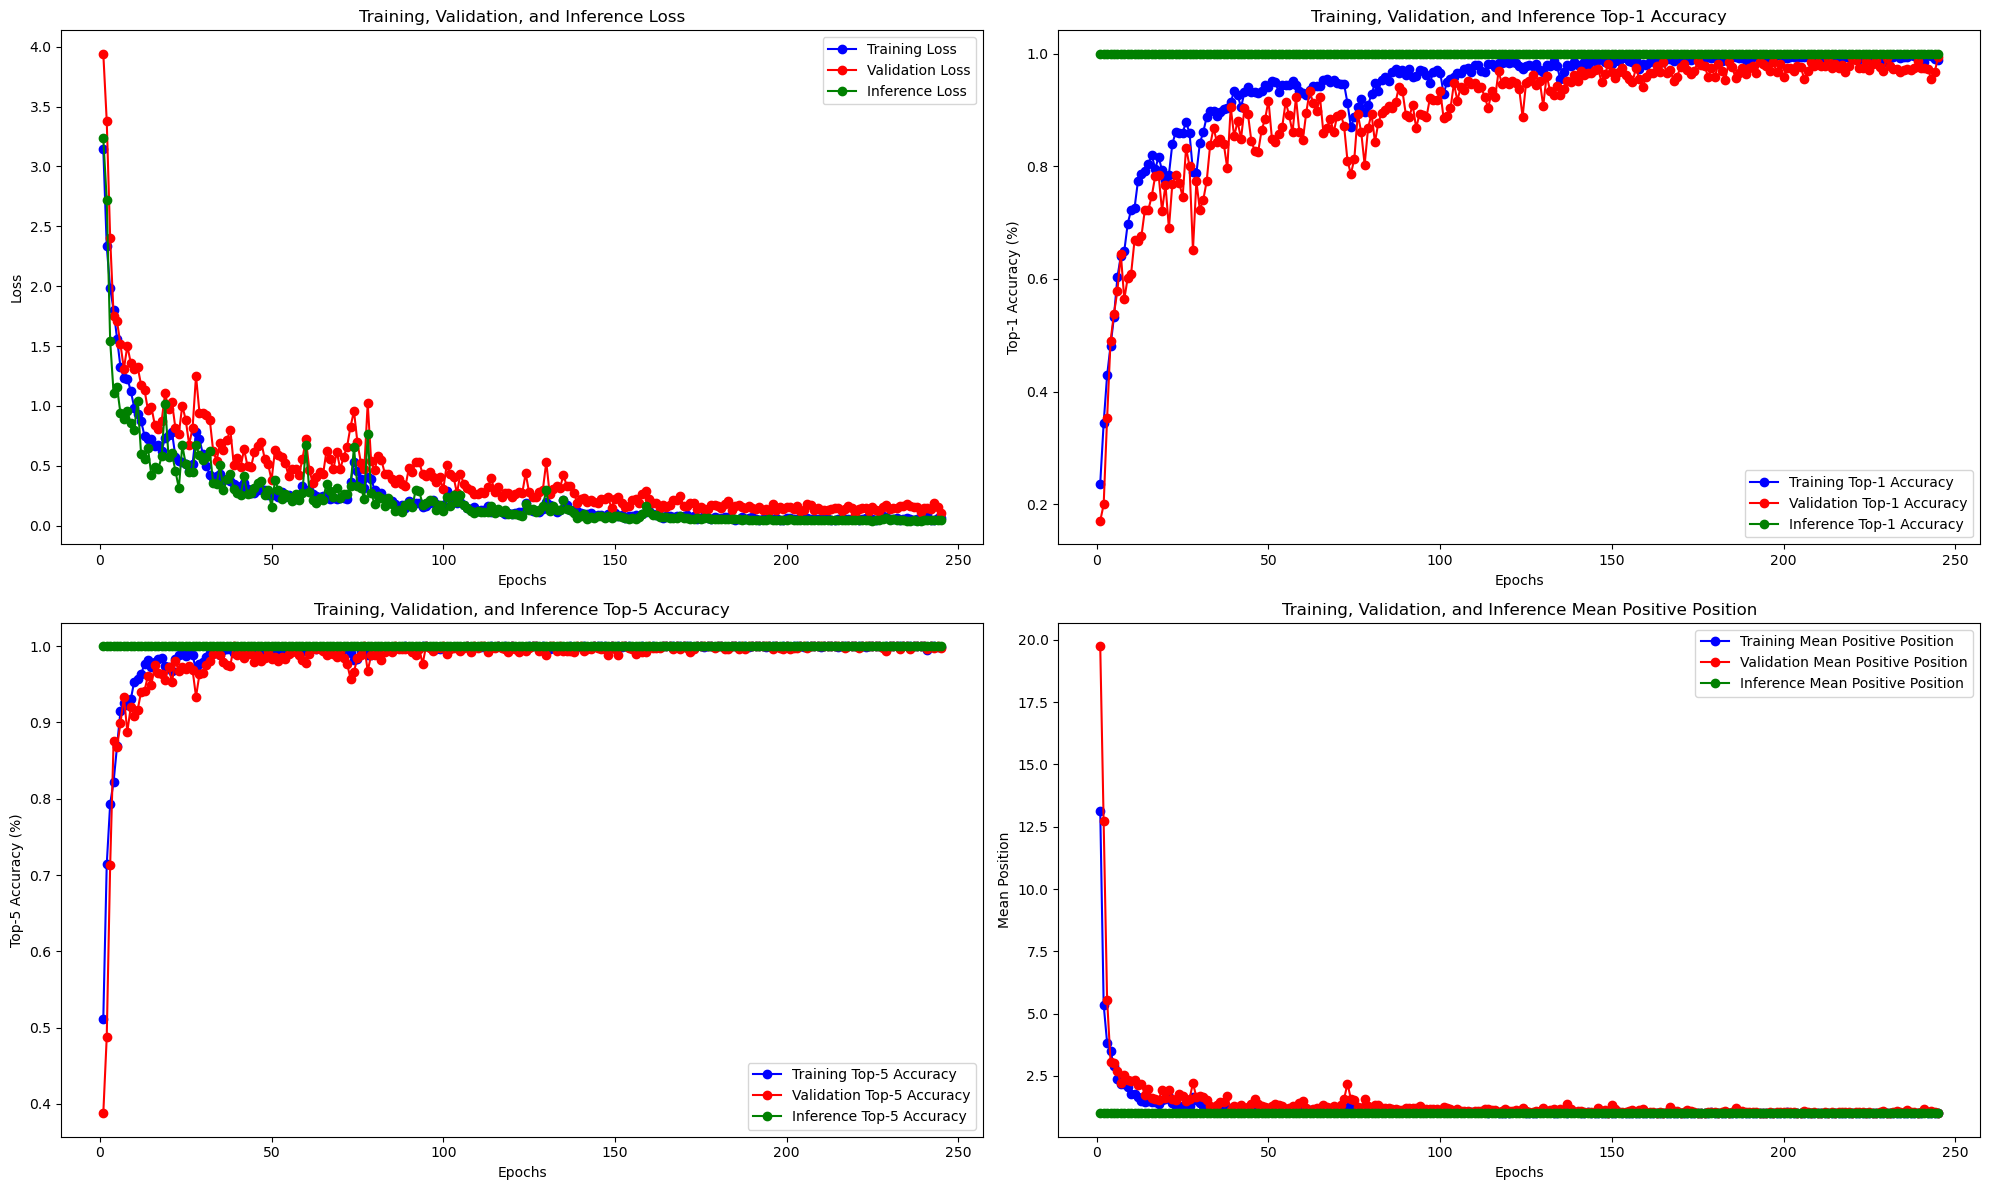

In [20]:
# Run the training script
simclr_model, metrics = train_simclr(
    batch_size=64,
    hidden_dim=128,
    lr=5e-4,
    temperature=0.07,
    weight_decay=1e-4,
    max_epochs=245, 
)


In [21]:
metrics

{'train_losses': [3.1461689273516336,
  2.3349552313486734,
  1.982532056172689,
  1.8020066837469737,
  1.5616044829289117,
  1.325347489429017,
  1.2357205291589102,
  1.2270187298456827,
  1.128241266523643,
  0.9859644810358683,
  0.9322616027047237,
  0.874962846445851,
  0.7507696603735288,
  0.725908957918485,
  0.7247622098249848,
  0.6684848359785974,
  0.6781284945396086,
  0.6268998513619105,
  0.731976467370987,
  0.7598495930433273,
  0.7817912743271639,
  0.5768821585768212,
  0.5401043684842686,
  0.5283475112480421,
  0.5160753252993648,
  0.45331517997353027,
  0.5153451164563497,
  0.780438111225764,
  0.7221846654390295,
  0.5987919541075826,
  0.5007248410178969,
  0.423976750485599,
  0.39501334145121897,
  0.41193859428167345,
  0.435120842885226,
  0.3778247084158162,
  0.3937107617035508,
  0.36995783903015156,
  0.34692558206928276,
  0.32846332918852567,
  0.30307098088087514,
  0.35546653817097346,
  0.30932919134696324,
  0.27225479199939095,
  0.27383735030

In [22]:
simclr_model

SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [23]:
# Define file paths
model_path = r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth'
metrics_path = r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_metrics_epoch_245.pth'

# Save the model separately
torch.save(simclr_model.state_dict(), model_path)  # Save only the model's weights (state_dict)

# Save the metrics separately
torch.save(metrics, metrics_path) 

C:\Users\k54739\AppData\Local\Temp\ipykernel_7052\2307106167.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load(metrics_path)


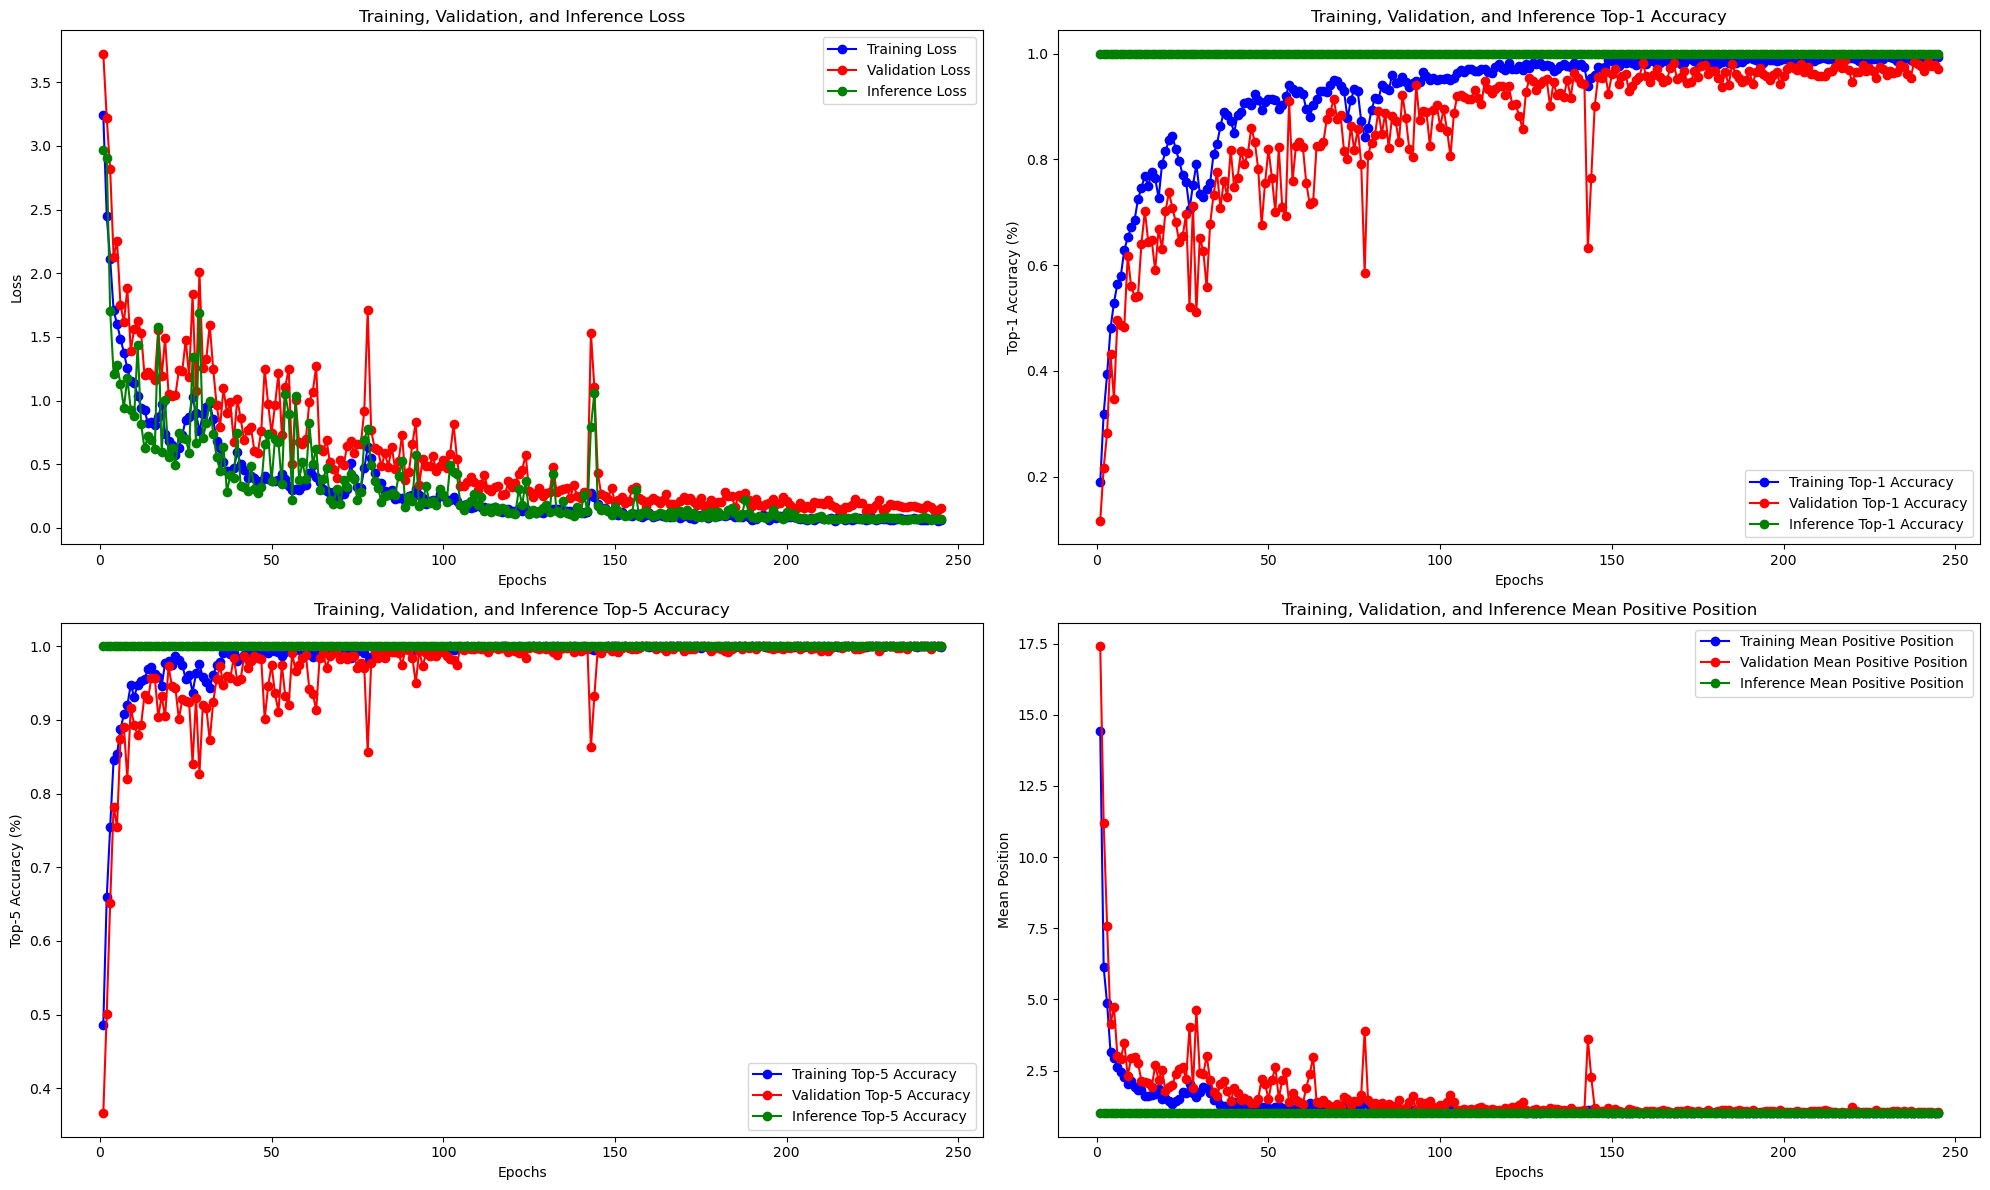

In [6]:
import matplotlib.pyplot as plt
metrics_path = r'C:\Users\k54739\saved_model\simclr_metrics_epoch_245.pth'
# Load the metrics
metrics = torch.load(metrics_path)
def plot_metrics(metrics):
    epochs = range(1, 246)  # Since you mentioned training for 245 epochs
    
    # Extract metrics from the dictionary
    train_losses = metrics["train_losses"]
    val_losses = metrics["val_losses"]
    inference_losses = metrics["inference_losses"]
    train_top1_accs = metrics["train_top1_accs"]
    val_top1_accs = metrics["val_top1_accs"]
    inference_top1_accs = metrics["inference_top1_accs"]
    train_top5_accs = metrics["train_top5_accs"]
    val_top5_accs = metrics["val_top5_accs"]
    inference_top5_accs = metrics["inference_top5_accs"]
    train_mean_pos = metrics["train_mean_pos"]
    val_mean_pos = metrics["val_mean_pos"]
    inference_mean_pos = metrics["inference_mean_pos"]
    
    # Plot Loss
    plt.figure(figsize=(20, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.plot(epochs, inference_losses, 'go-', label='Inference Loss')
    plt.title('Training, Validation, and Inference Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.plot(epochs, inference_top1_accs, 'go-', label='Inference Top-1 Accuracy')
    plt.title('Training, Validation, and Inference Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.plot(epochs, inference_top5_accs, 'go-', label='Inference Top-5 Accuracy')
    plt.title('Training, Validation, and Inference Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.plot(epochs, inference_mean_pos, 'go-', label='Inference Mean Positive Position')
    plt.title('Training, Validation, and Inference Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with your metrics
plot_metrics(metrics)


In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

NameError: name 'torch' is not defined

In [2]:
# Reinitialize the model
model_path = r'C:\Users\k54739\saved_model\simclr_model_epoch_245.pth'
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)

# Load the metrics
#loaded_metrics = torch.load(metrics_path)


NameError: name 'SimCLR' is not defined

Inference before projection head

In [13]:
#torch.save(simclr_model.state_dict(), 'model_weights.pth')
#full_model_path =  r'C:\Users\k54739\saved_model\simclr_modelepoch250.pth' 
#torch.save(simclr_model, full_model_path)

In [14]:
#simclr_model = torch.load(full_model_path)
simclr_model.eval()

SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [15]:
from copy import deepcopy
import torchvision.transforms.functional as TF

In [16]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    return image


In [18]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff'

In [19]:
first_image = Preprocess_Image(path_of_image)
print(first_image.shape)
prep_first_image = first_image.unsqueeze(0)
print(prep_first_image.shape)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


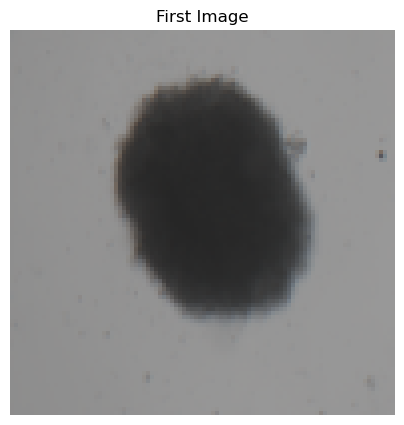

In [20]:
first_image_np = first_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(first_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('First Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [21]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff'
second_image = Preprocess_Image(pathimage)
print(second_image.shape)
prep_second_image = second_image.unsqueeze(0)
print(prep_second_image.shape)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


In [22]:
second_image.shape

torch.Size([3, 96, 96])

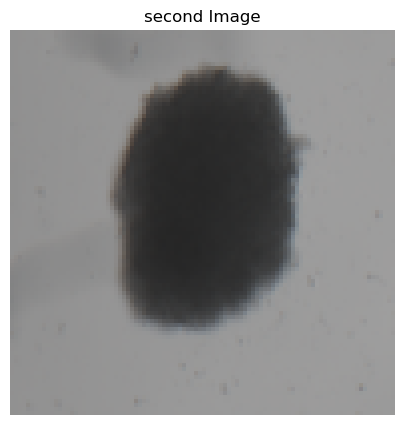

In [23]:
second_image_np = second_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(second_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [24]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [25]:
print(f"simclr_model: {simclr_model}")

simclr_model: SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [26]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, prep_first_image)
second_image_feats = extract_features(simclr_model, prep_second_image)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [27]:
# COSINE FROM NEWDATA CROP VAL&INFER
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.821189820766449


In [20]:
# COSINE old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.8204046487808228


In [28]:
im_path = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff'
untreated_image = Preprocess_Image(im_path)
print(untreated_image.shape)
prep_untreated_image = untreated_image.unsqueeze(0)
print(prep_untreated_image.shape)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


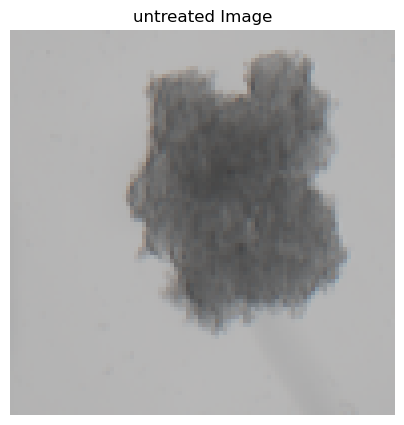

In [29]:
untreated_image_np = untreated_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(untreated_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('untreated Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [30]:
untreated_image_feats = extract_features(simclr_model, prep_untreated_image)

In [31]:
# COSINE NEW DATA CROP
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.298863023519516


In [24]:
# cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.19446787238121033


Inference after projection head

In [32]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [33]:
# Extract features for both images
first_image_feats_after = features_after_projection(simclr_model, prep_first_image)
second_image_feats_after = features_after_projection(simclr_model, prep_second_image)
print(first_image_feats_after.shape)
print(second_image_feats_after.shape)

torch.Size([1, 20])
torch.Size([1, 20])


In [35]:
# Cosine newdata crop 
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.55315762758255


In [ ]:
# Cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

#Cosine similarity between features: 0.8507535457611084


as expected after projection head cosine similarity is higher this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

In [36]:
untreated_image_feats_after = features_after_projection(simclr_model, prep_untreated_image)
print(untreated_image_feats_after.shape)

torch.Size([1, 20])


In [37]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.26108598709106445


In [29]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.18768171966075897


as expected after projection head cosine similarity is lower for different class images this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

Orig images (without simclr)

In [48]:
print(first_image)
first_image.view(-1).shape


tensor([[[0.5470, 0.5567, 0.5606,  ..., 0.5938, 0.5943, 0.5934],
         [0.5529, 0.5582, 0.5605,  ..., 0.5936, 0.5938, 0.5925],
         [0.5568, 0.5596, 0.5608,  ..., 0.5942, 0.5940, 0.5944],
         ...,
         [0.5541, 0.5543, 0.5565,  ..., 0.5892, 0.5886, 0.5892],
         [0.5542, 0.5552, 0.5562,  ..., 0.5879, 0.5885, 0.5889],
         [0.5540, 0.5557, 0.5556,  ..., 0.5879, 0.5893, 0.5899]],

        [[0.5493, 0.5567, 0.5601,  ..., 0.5925, 0.5925, 0.5928],
         [0.5534, 0.5577, 0.5596,  ..., 0.5928, 0.5925, 0.5917],
         [0.5566, 0.5582, 0.5598,  ..., 0.5935, 0.5934, 0.5935],
         ...,
         [0.5527, 0.5535, 0.5554,  ..., 0.5882, 0.5880, 0.5887],
         [0.5528, 0.5538, 0.5552,  ..., 0.5873, 0.5875, 0.5885],
         [0.5527, 0.5552, 0.5550,  ..., 0.5877, 0.5885, 0.5891]],

        [[0.5513, 0.5575, 0.5597,  ..., 0.5920, 0.5915, 0.5917],
         [0.5549, 0.5581, 0.5595,  ..., 0.5924, 0.5924, 0.5921],
         [0.5574, 0.5582, 0.5601,  ..., 0.5923, 0.5935, 0.

torch.Size([27648])

In [49]:
print(second_image)
second_image.view(-1).shape

tensor([[[0.5667, 0.5681, 0.5692,  ..., 0.6117, 0.6131, 0.6123],
         [0.5668, 0.5676, 0.5689,  ..., 0.6129, 0.6132, 0.6120],
         [0.5672, 0.5673, 0.5695,  ..., 0.6136, 0.6136, 0.6136],
         ...,
         [0.5707, 0.5719, 0.5733,  ..., 0.6065, 0.6071, 0.6066],
         [0.5709, 0.5718, 0.5733,  ..., 0.6054, 0.6066, 0.6055],
         [0.5712, 0.5710, 0.5731,  ..., 0.6048, 0.6062, 0.6054]],

        [[0.5658, 0.5665, 0.5675,  ..., 0.6108, 0.6114, 0.6110],
         [0.5656, 0.5661, 0.5677,  ..., 0.6119, 0.6123, 0.6115],
         [0.5656, 0.5665, 0.5685,  ..., 0.6126, 0.6120, 0.6122],
         ...,
         [0.5698, 0.5702, 0.5724,  ..., 0.6060, 0.6059, 0.6056],
         [0.5689, 0.5699, 0.5719,  ..., 0.6044, 0.6053, 0.6034],
         [0.5692, 0.5697, 0.5727,  ..., 0.6040, 0.6049, 0.6042]],

        [[0.5648, 0.5659, 0.5666,  ..., 0.6107, 0.6111, 0.6106],
         [0.5654, 0.5659, 0.5673,  ..., 0.6115, 0.6118, 0.6110],
         [0.5651, 0.5663, 0.5677,  ..., 0.6125, 0.6118, 0.

torch.Size([27648])

In [40]:
first_flat = first_image.view(-1)
second_flat = second_image.view(-1)

In [55]:
first_flat.unsqueeze(0).shape == untreated_flat.unsqueeze(0)

False

In [42]:
import torch.nn.functional as F
similarity = F.cosine_similarity(first_flat.unsqueeze(0), second_flat.unsqueeze(0))
similarity

tensor([0.9914])

In [44]:
untreated_flat = untreated_image.view(-1)

In [46]:
similarity = F.cosine_similarity(first_flat.unsqueeze(0), untreated_flat.unsqueeze(0))
similarity

tensor([0.9834])

In [50]:
first_flat == untreated_flat

tensor([False, False, False,  ..., False, False, False])

orig without resizing

In [60]:
import numpy as np
import tifffile as tiff
from numpy.linalg import norm

# Load and normalize both images
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")


(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9906225204467773


In [61]:
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")

(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9821854829788208


In [62]:
WAS IST DAS?
Mach kein Sinn!

SyntaxError: invalid syntax (2322824841.py, line 2)

In [74]:
img1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
img2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')
img3 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')
img1_flattened = img1.flatten()
img2_flattened = img2.flatten()
img3_flattened = img3.flatten()

In [72]:
cosine_similarity = np.dot(img1_flattened, img2_flattened) / (norm(img1_flattened) * norm(img2_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 3.129988785460241e-12


In [77]:
cosine_similarity = np.dot(img1_flattened, img3_flattened) / (norm(img1_flattened) * norm(img3_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 1.0155029384685969e-13


In [69]:
img1

array([[[34168, 35304, 34600, ..., 39241, 39289, 39033],
        [34168, 35224, 34568, ..., 39225, 38569, 38761],
        [34280, 34984, 35048, ..., 38249, 38249, 39817],
        ...,
        [36792, 35864, 36200, ..., 38009, 36376, 38729],
        [36889, 36504, 36504, ..., 40025, 38297, 38041],
        [36280, 37209, 35656, ..., 37753, 37849, 39897]],

       [[36328, 35848, 34584, ..., 39785, 39609, 38585],
        [35032, 34168, 35944, ..., 39609, 39673, 38201],
        [36392, 35608, 35112, ..., 36953, 39433, 38585],
        ...,
        [35736, 35528, 35240, ..., 39017, 37369, 39017],
        [35144, 35464, 36937, ..., 38697, 38921, 38569],
        [35976, 35752, 35928, ..., 39513, 38921, 37897]],

       [[36680, 35688, 36104, ..., 39977, 39001, 38137],
        [35208, 35848, 35480, ..., 39401, 38681, 37321],
        [35240, 35272, 34856, ..., 37705, 39673, 38265],
        ...,
        [35992, 35560, 34696, ..., 37513, 38393, 38745],
        [35496, 34392, 35272, ..., 37929, 388

In [76]:
img2

array([[[37577, 37369, 36792, ..., 39769, 41050, 39209],
        [37689, 36440, 36873, ..., 39929, 40105, 39881],
        [36728, 37337, 36488, ..., 39097, 40521, 40249],
        ...,
        [37561, 37577, 37449, ..., 38793, 38137, 40297],
        [35784, 38121, 37833, ..., 40025, 39689, 39481],
        [38345, 37065, 38569, ..., 39561, 39497, 39753]],

       [[37321, 37529, 36840, ..., 39881, 39961, 41162],
        [36440, 37049, 37049, ..., 40089, 39321, 40889],
        [36056, 36136, 36376, ..., 38713, 40009, 39321],
        ...,
        [36873, 37625, 38121, ..., 39065, 38425, 39737],
        [36889, 37625, 36328, ..., 39929, 39801, 39033],
        [38233, 37385, 38905, ..., 38953, 38809, 39593]],

       [[36969, 36536, 36536, ..., 41098, 41050, 39577],
        [36680, 36296, 36728, ..., 40073, 40970, 39929],
        [36824, 37353, 37241, ..., 39881, 40249, 40697],
        ...,
        [37449, 37097, 37145, ..., 39177, 38409, 40233],
        [37465, 37993, 37865, ..., 39273, 401

In [75]:
img3

array([[[46155, 46875, 44570, ..., 46283, 45947, 44842],
        [46987, 46747, 45995, ..., 47003, 47467, 46251],
        [45403, 46635, 45915, ..., 45387, 46059, 46059],
        ...,
        [45675, 46555, 44666, ..., 45563, 44538, 47003],
        [46091, 45563, 45851, ..., 47083, 46811, 45435],
        [45131, 45787, 46475, ..., 45995, 45835, 46795]],

       [[46891, 45819, 45979, ..., 46299, 46683, 46507],
        [45371, 45675, 46315, ..., 46427, 45403, 45307],
        [45531, 45307, 45723, ..., 44266, 44858, 45979],
        ...,
        [45707, 45627, 45819, ..., 44538, 44922, 46667],
        [46539, 45611, 45147, ..., 46315, 45755, 45034],
        [45179, 45659, 45851, ..., 46779, 46411, 46011]],

       [[45531, 46171, 45883, ..., 45915, 45579, 46795],
        [46363, 47003, 46331, ..., 46507, 44922, 46507],
        [45531, 45515, 46203, ..., 44554, 45467, 45707],
        ...,
        [45707, 44858, 45451, ..., 45131, 45259, 45691],
        [45787, 47019, 44842, ..., 45819, 453

so, if we didn't use simclr and just try to find the cosine similarity between orig images: it doesn't deviate too  much not good.